In [1]:
import os
# Ignore TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.datasets import imdb

from deepthink.layers import EmbeddingLayer, GlobalAveragePooling, Dense
from deepthink.model import Model
from deepthink.optimizers import Adam
from deepthink.loss import BinaryCrossEntropy
from deepthink.activations import Sigmoid
from deepthink.utils import pad_sequences

# Set default matplotlib style
plt.style.use('ggplot')

## IMDB Sentiment Analysis

The purpose of this notebook is to demonstrate text-classification using [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). This example is inspired by [this](https://www.tensorflow.org/tutorials/keras/text_classification) TensorFlow tutorial.

#### IMDB Dataset

The dataset used is the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), which consists of 50,000 movie reviews from [imdb.com](https://www.imdb.com/) split into 25,000 for training and 25,000 for testing. Each review is classed as positive or negative (1 or 0 respectively) and the goal is to predict this from the review text. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).

In [2]:
# Define the parameters
max_features = 10000  # Maximum vocab size
seq_len = 200  # Maximum length of each review
embedding_dim = 16
batch_size = 32
epochs = 10
learning_rate = 0.001

In [3]:
# Load the data
(train_text, train_labels), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Reshape labels to column vector
train_labels = train_labels.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(train_text.shape, train_labels.shape)
print(X_test.shape, y_test.shape)

(25000,) (25000, 1)
(25000,) (25000, 1)


In [4]:
# View a sample review
sample = np.random.choice(train_text)
# Get the word index for each word in the review
word_to_idx = imdb.get_word_index()
# Create a reverse word index
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Convert the review to text
review = ' '.join([idx_to_word.get(idx - 3, '?') for idx in sample])
print(review)

? philo vance had many ? with ? ? he was a gentleman with the kind of polish and ? only usually associated with the british upper classes and he was also ? ? br br but there were vital ? ? was an ? charming ? ? vance could be pompous ? dull and self ? there was a hint of fundamental cruelty in his ? br br the ? murder case is the most impressive of the 14 vance films made between ? and ? the story of a murdered collector of ? it has all the ingredients of the classic private eye mystery  exotic setting in the blue nose long island ? club three killings for vance to solve including a ? locked room murder the key to the whole affair and plenty of ? br br usually a detective story setting have proved too static and ? to make convincing movies even though they work well enough on the ? page but here michael ? direction and the fine editing give the film a pace and urgency that make it altogether different from similar films of its ? br br william ? ? and ? made him the perfect vance and a

In [5]:
# Pad the sequences
train_text = pad_sequences(train_text, seq_len)
X_test = pad_sequences(X_test, seq_len)

In [6]:
# Shuffle the data and split into training and validation sets
# (20k training, 5k validation as per the TensorFlow tutorial)
train_size = 20000
random_perm = np.random.permutation(train_text.shape[0])
train_text = train_text[random_perm]
train_labels = train_labels[random_perm]

X_train = train_text[:train_size]
y_train = train_labels[:train_size]
X_valid = train_text[train_size:]
y_valid = train_labels[train_size:]

In [7]:
# Define the model
opt = Adam(learning_rate=learning_rate)
model = Model(opt, cost=BinaryCrossEntropy(),
              batch_size=batch_size,
              metrics=['accuracy'])

model.add_layer(EmbeddingLayer(max_features, embedding_dim,
                               input_shape=(batch_size, seq_len)))
model.add_layer(GlobalAveragePooling())
model.add_layer(Dense(1))
model.add_layer(Sigmoid())

model.initialize()

In [8]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Embedding Layer           (None, 16, 200)                  160000
GlobalAveragePooling      (None, 16)                            0
Dense(1)                  (None, 1)                            17
Sigmoid Activation        (None, 1)                             0
Total params: 160017


In [9]:
history = model.train((X_train, y_train),
                      validation_data=(X_valid, y_valid),
                      epochs=epochs)

100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 82.60it/s]


Epoch: 1/10, elapsed-time: 7.78s - loss: 0.5820 - accuracy: 0.7930 - val_loss: 0.5850 - val_accuracy: 0.7841 - 


100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 83.59it/s]


Epoch: 2/10, elapsed-time: 15.30s - loss: 0.5135 - accuracy: 0.8153 - val_loss: 0.4622 - val_accuracy: 0.8275 - 


100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 82.78it/s]


Epoch: 3/10, elapsed-time: 22.91s - loss: 0.4071 - accuracy: 0.8560 - val_loss: 0.3949 - val_accuracy: 0.8425 - 


100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 80.90it/s]


Epoch: 4/10, elapsed-time: 30.68s - loss: 0.3455 - accuracy: 0.8760 - val_loss: 0.3608 - val_accuracy: 0.8522 - 


100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 80.83it/s]


Epoch: 5/10, elapsed-time: 38.47s - loss: 0.3067 - accuracy: 0.8894 - val_loss: 0.3417 - val_accuracy: 0.8608 - 


100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 81.40it/s]


Epoch: 6/10, elapsed-time: 46.20s - loss: 0.2787 - accuracy: 0.8991 - val_loss: 0.3293 - val_accuracy: 0.8650 - 


100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 81.79it/s]


Epoch: 7/10, elapsed-time: 53.89s - loss: 0.2564 - accuracy: 0.9062 - val_loss: 0.3216 - val_accuracy: 0.8676 - 


100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 83.28it/s]


Epoch: 8/10, elapsed-time: 61.45s - loss: 0.2377 - accuracy: 0.9139 - val_loss: 0.3189 - val_accuracy: 0.8692 - 


100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 81.37it/s]


Epoch: 9/10, elapsed-time: 69.18s - loss: 0.2221 - accuracy: 0.9198 - val_loss: 0.3160 - val_accuracy: 0.8704 - 


100%|███████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:07<00:00, 81.08it/s]


Epoch: 10/10, elapsed-time: 76.94s - loss: 0.2080 - accuracy: 0.9261 - val_loss: 0.3155 - val_accuracy: 0.8726 - 


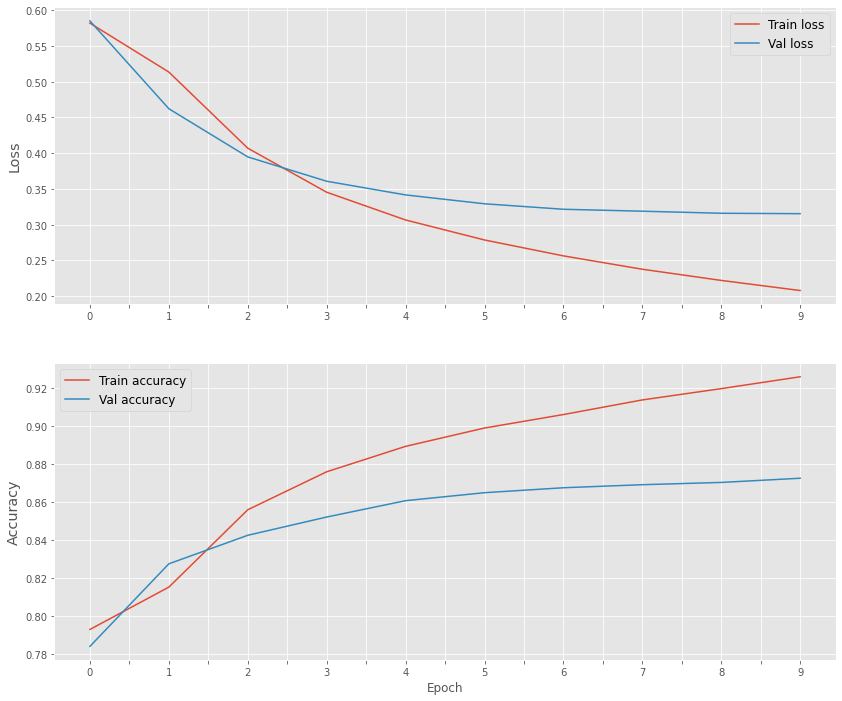

In [10]:
# Plot training history

history.plot_history()

In [11]:
# Evaluate on test data
test_preds = model.get_predictions(X_test)
test_labels = y_test[:test_preds.shape[0]]
test_loss = BinaryCrossEntropy()(test_labels, test_preds)
binary_preds = np.round(test_preds)
test_acc = np.mean(binary_preds == test_labels)


print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2%}')


Test Loss: 0.3250
Test Accuracy: 86.42%
